# 인스타 사진을 예측하고 예측한 관광지에 대한 설명을 해주는 앱만들기

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os, random, re

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.image import central_crop, pad_to_bounding_box, resize
from tensorflow.keras.models import Model, load_model

## 필요한 데이터 가져오기

In [4]:
# 라벨정보를 위한 데이터
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                rotation_range=40,
                                #shear_range=30,
                                brightness_range=(0.3, 2.0),
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.5,
                                horizontal_flip=True,
                                  )
validataion_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
target_size = (128, 128)
batch_size = 20
train_generator = train_datagen.flow_from_directory('tour_img_gen/train', target_size = target_size, batch_size = batch_size)
validataion_generator = validataion_datagen.flow_from_directory('tour_img_gen/validation', target_size = target_size, batch_size = batch_size)
test_generator = test_datagen.flow_from_directory('tour_img_gen/test/', target_size = target_size, batch_size = batch_size)

Found 17871 images belonging to 47 classes.
Found 5957 images belonging to 47 classes.
Found 5957 images belonging to 47 classes.


In [6]:
# 사용할 모델 가져오기
model = load_model('deep_model/DenseNet.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 134, 134, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                            

 conv2_block4_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block11_0_bn (BatchNorma  (None, 16, 16, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization) 

 conv4_block7_1_conv (Conv2D)   (None, 8, 8, 128)    57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block20_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
          

                                                                                                  
 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 8, 8, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 8, 8, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 8, 8, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_poo

 conv5_block4_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 4, 4, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 4, 4, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 4, 4, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 4, 4, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 4, 4, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 4, 4, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_blo

In [2]:
# 모델 성능 확인
model.evaluate_generator(test_generator)

NameError: name 'model' is not defined

In [20]:
# 라벨 정보 가져오기
df_info = pd.read_excel('data_file/나라별 여행지 라벨 정보.xlsx')

In [21]:
df_info

,나라,관광지,en나라,en관광지,정보
0,그리스,올림피아 제우스 신전,Greece,Temple of Olympian Zeus,크레타 섬을 제외하고 키클라데스 제도 최남단에 있는 그리스 에게 해의 섬이다. 이 ...
1,그리스,아테네의 아고라,Greece,Ancient Agora of Athens,"헤파이스토스 신전 또는 헤파이스테이온(고대 그리스어: Ἡφαιστεῖον, 그리스어..."
2,그리스,산토리니,Greece,Santorini,크레타 섬을 제외하고 키클라데스 제도 최남단에 있는 그리스 에게 해의 섬이다. 이 ...
3,독일,노이슈반슈타인 성,Germany,Neuschwanstein,노이슈반슈타인성(독일어: Schloß/Schloss Neuschwanstein)은 ...
4,독일,브란덴부르크 문,Germany,Brandenburg Gate,브란덴부르크 문(독일어: Brandenburger Tor)은 18세기에 베를린에 지...
5,독일,베를린 대성당,Germany,Berliner Dom,베를리너 돔(독일어: Berliner Dom)은 독일 베를린에 있는 독일 개신교 교...
6,독일,함부르크 시청사,Germany,Hamburg Town Hall,1879년 완공된 네오 르네상스 양식의 건물. 647개의 방이 있다고 하면 그 규모...
7,독일,쾰른 대성당,Germany,Cologne Cathedral,"쾰른 대성당(독일어: Kölner Dom, 정식 명칭: Hohe Domkirche ..."
8,독일,플뢴라인,Germany,Plonlein,로텐부르크의 옛 모습 가득한 시가지 중에서도 으뜸으로 그림같은 풍경을 연출하는 곳....
9,스페인,사그라다 파밀리아,Spain,Sagrada Familia,사그라다 파밀리아 성당(카탈루냐어: Temple Expiatori de la Sag...


In [4]:
# 테스트용 인스타사진 전처리후 가져오기
names = os.listdir('test_img')
x = []
y = []
size = (128, 128)
for name in names:
        path = f"test_img"
        print(name, 'transform')
        img = load_img(f"{path}/{name}")
        img_array = img_to_array(img) / 255
        img_resize = resize(img_array, size)
        x.append(np.array(img_resize))
        y.append(name.replace('.jpg', '').replace('1', ''))

NameError: name 'os' is not defined

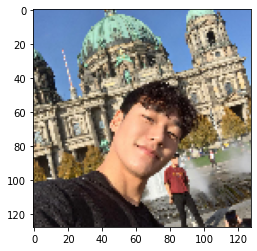

In [24]:
# 입력용 사진확인
plt.imshow(x[0])

In [25]:
# 출력용 라벨확인
y

['Berliner Dom',
 'Berliner Dom',
 'Blue Mosque',
 'Blue Mosque',
 'Chapel Bridge',
 'Chapel Bridge',
 'Colosseum',
 'Eiffel Tower',
 'Eiffel Tower',
 'Grgur Ninski Statue',
 'Grgur Ninski Statue',
 'Manneken Pis',
 'Manneken Pis',
 'Mosteiro dos Jeronimos',
 'Mosteiro dos Jeronimos',
 'Sagrada Familia',
 'Sagrada Familia',
 'Santorini',
 'Santorini',
 "St. Stephen's Cathedral",
 "St. Stephen's Cathedral",
 'Staromestske namesti',
 'Staromestske namesti',
 'Tower Bridge',
 'Tower Bridge',
 'Trevi Fountain',
 'Trevi Fountain']

## 데이터 전처리

In [26]:
le = LabelEncoder()
y_le = le.fit_transform(y)

In [27]:
y_oh = to_categorical(y_le)

In [28]:
x_test = x
y_test = y_oh

In [32]:
# float형태 변경
np.set_printoptions(suppress=True)

In [ ]:
# 실제값을 딕셔너리 형태로 만듬
di = train_generator.class_indices
y_label_dict = dict(zip(di.values(),di.keys()))

## 사진을 통한 관광지 예측

In [31]:
# 테스트 사진 관광지 에측
preds = model.predict(np.array(x_test))

In [ ]:
# 46가지 라벨의 예상 확률을 리스트 형태로 나타낸다
print(preds[0] * 100)

In [36]:
# 가장 활률이 높은 라벨의 관광지명 출력
print(y_label_dict[np.argmax(preds[0])])

[ 0.0000017   0.02986173  0.00030761  0.00219729  0.00000135  0.00022212
 98.93761     0.00631578  0.00000006  0.00121423  0.00330518  0.00012523
  0.00488184  0.00004989  0.00257747  0.00001794  0.          0.00028655
  0.0000142   0.00035658  0.02288919  0.00005278  0.00076397  0.00122708
  0.00000006  0.00001582  0.04414069  0.00750154  0.00000005  0.00000593
  0.00011542  0.00000026  0.00000062  0.00011998  0.00513947  0.00000002
  0.00000218  0.02848806  0.2979364   0.4199862   0.14887838  0.00000002
  0.00000108  0.00363794  0.029752    0.00000362  0.00000089]
Berliner Dom


In [34]:
# 26장의 테스트 사진 예측값과 실제값 비교
for i in range(len(x_test)):
    print(max(preds[i]) * 100)
    print('True value:', y[i])
    print('predict value:', y_label_dict[np.argmax(preds[i])])
    print('=' * 50)

98.93760681152344
True value: Berliner Dom
predict value: Berliner Dom
99.98589754104614
True value: Berliner Dom
predict value: Berliner Dom
21.551939845085144
True value: Blue Mosque
predict value: St. Stephen's Cathedral
86.63948178291321
True value: Blue Mosque
predict value: Blue Mosque
26.62229835987091
True value: Chapel Bridge
predict value: St. Paul's Cathedral
51.366060972213745
True value: Chapel Bridge
predict value: Chapel Bridge
99.66062307357788
True value: Colosseum
predict value: Colosseum
17.13375747203827
True value: Eiffel Tower
predict value: Eiffel Tower
41.72084033489227
True value: Eiffel Tower
predict value: Eiffel Tower
63.280993700027466
True value: Grgur Ninski Statue
predict value: Grgur Ninski Statue
83.15366506576538
True value: Grgur Ninski Statue
predict value: Grgur Ninski Statue
27.37971842288971
True value: Manneken Pis
predict value: Trevi Fountain
38.06447982788086
True value: Manneken Pis
predict value: St. Paul's Cathedral
44.4416344165802
True v

## 관광지 예측및 설명해주는 앱만들기

In [7]:
def img_search(tour):
    path = f'tour_img_gen/train/{tour}/'
    dir_list = os.listdir(path)
    file_name = dir_list[random.randrange(1, len(dir_list))]
    file_name
    img = load_img(path+file_name)
    img_array = img_to_array(img) / 255
    img = np.array(resize(img_array, (360, 360)))

    return img

In [14]:
def predict_img(path):
    di = train_generator.class_indices
    y_label_dict = dict(zip(di.values(),di.keys()))
    size = (128, 128)
    fig, axs = plt.subplots(1, 2, figsize=(10,10))
    img_pre = load_img(path)
    img_pre = img_to_array(img_pre) / 255
    img_pre = resize(img_pre, size)
    img_pre = np.array(img_pre)
    axs[0].imshow(img_pre)
    axs[0].set_title('input img')
    img_pre = tf.expand_dims(img_pre, axis=0)
    preds = model.predict(img_pre)

    print('accuracy :', round(max(preds[0]) * 100, 1))
    print('predict value:', y_label_dict[np.argmax(preds[0])])
    img = img_search(y_label_dict[np.argmax(preds[0])])

    axs[1].imshow(img)
    axs[1].set_title('predict tour img')
    print('=' * 50)
    print(df_info[df_info['en관광지'] == y_label_dict[np.argmax(preds[0])]]['정보'].values[0])
    print('=' * 50)

accuracy : 34.4
predict value: Hamburg Town Hall
1879년 완공된 네오 르네상스 양식의 건물. 647개의 방이 있다고 하면 그 규모를 실감할 수 있을까? 궁전을 연상케 하는 시청사(Rathaus)의 외관은 부유한 무역항 함부르크의 풍요에 걸맞는 위엄을 보인다. 한자동맹 당시 시 정부나 시 의회의 소재지였으며, 유럽에서 가장 오래 된 증권 거래소도 위치하고 있다.


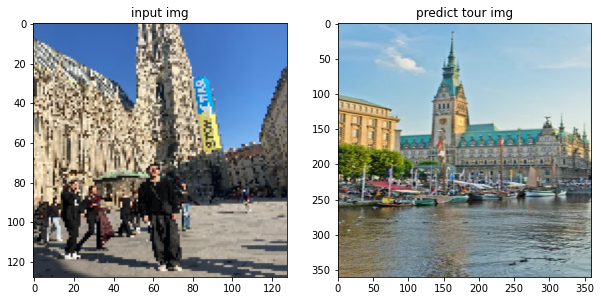

In [57]:
path = "test_img/St. Stephen's Cathedral.jpg"
predict_img(path)